In [419]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as PipelineImblearn
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from gensim.models import Word2Vec
from imblearn.over_sampling  import RandomOverSampler
import gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import warnings
import time
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef

In [264]:
dataFrameWithSentiment = pd.read_csv('/Users/rakshith/employee_reviews_labelled.csv')


dataFrameWithSentiment.drop(columns= ['Unnamed: 0'], inplace= True)


In [265]:
warnings.filterwarnings('ignore')

In [266]:
dataFrameWithSentiment.head()


,company,location,Year,Month,EmployeeType,FunctionHR,FunctionSDevelopment,FunctionFinance,FunctionMarketing,RoleLead,RoleSenior,RoleManager,RoleIntern,summary,pros,cons,advice-to-mgmt,ReviewCombined,Senti,ManagementSentiment
0,google,none,2018,Dec,Current Employee,0,0,0,0,0,0,0,0,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,Best Company to work for People are smart and ...,Positive,Negative
1,google,"Mountain View, CA",2013,Jun,Former Employee,0,0,0,0,0,0,1,0,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,"Moving at the speed of light, burn out is inev...",Positive,Positive
2,google,"New York, NY",2014,May,Current Employee,0,1,0,0,0,0,0,0,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,Great balance between big-company security and...,Positive,Negative
3,google,"Mountain View, CA",2015,Feb,Current Employee,0,0,0,0,0,0,0,0,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,The best place I've worked and also the most d...,Positive,Positive
4,google,"Los Angeles, CA",2018,Jul,Former Employee,0,1,0,0,0,0,0,0,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,"Unique, one of a kind dream job Google is a wo...",Positive,Positive


In [267]:
dataFrameWithSentiment.shape

(52725, 20)

In [268]:
dataFrameWithSentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52725 entries, 0 to 52724
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   company               52725 non-null  object
 1   location              52725 non-null  object
 2   Year                  52725 non-null  int64 
 3   Month                 52725 non-null  object
 4   EmployeeType          52725 non-null  object
 5   FunctionHR            52725 non-null  int64 
 6   FunctionSDevelopment  52725 non-null  int64 
 7   FunctionFinance       52725 non-null  int64 
 8   FunctionMarketing     52725 non-null  int64 
 9   RoleLead              52725 non-null  int64 
 10  RoleSenior            52725 non-null  int64 
 11  RoleManager           52725 non-null  int64 
 12  RoleIntern            52725 non-null  int64 
 13  summary               52653 non-null  object
 14  pros                  52725 non-null  object
 15  cons                  52725 non-null

In [269]:
#Extracting only text data

dataFrameReviewDataset = dataFrameWithSentiment[['ReviewCombined', 'Senti']].copy()

dataFrameReviewDataset.head()

,ReviewCombined,Senti
0,Best Company to work for People are smart and ...,Positive
1,"Moving at the speed of light, burn out is inev...",Positive
2,Great balance between big-company security and...,Positive
3,The best place I've worked and also the most d...,Positive
4,"Unique, one of a kind dream job Google is a wo...",Positive


### Utilities 

In [315]:
import nltk
from nltk.corpus import stopwords


def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', cleaned)
    return cleaned


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stopwordsEng = stopwords.words('english')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def lemmatizeText(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


from wordcloud import WordCloud


def wc(data, bgcolor, title):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(background_color=bgcolor,
                   max_words=2000,
                   random_state=42,
                   max_font_size=45)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.title = title
    plt.axis('off')


#Display confusion Matrix
def displayConfusionMatrix(conf_matrix, title):

    sns.set(font_scale=1.3)

    axis = sns.heatmap(conf_matrix,
                 annot=True,
                 fmt="",
                 cmap='cividis',
                 annot_kws={
                     'fontsize': 13,
                     'fontweight': 'normal',
                     'fontfamily': 'arial'
                 })
    
    axis.set_title(title)
    axis.set_xlabel('\nPredicted Values', )
    axis.set_ylabel('Actual Values ')
    #ax.tick_params(labelsize=13)

    ## Ticket labels - List must be in alphabetical order
    axis.xaxis.set_ticklabels(['Negative', 'Positive'])
    axis.yaxis.set_ticklabels(['Negative', 'Positive'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

#Saves the model with path and name given in 'modelName'
def saveModel(modelName, model):
    with open(modelName, 'wb') as f:
        pickle.dump(model, f)

#Retrieves the saved model from the disk, returns None if not found.        
def getModel(modelName):
    try:
        with open(modelName, 'rb') as f:
            model = pickle.load(f)
            return model
    except FileNotFoundError:
        return None

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rakshith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rakshith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rakshith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Converting sentiment values to numerical

In [271]:
dataFrameReviewDataset.rename(columns={
    "Senti": "sentiment",
    "ReviewCombined": "review"
},
                              inplace=True)

dataFrameReviewDataset["sentiment"] = dataFrameReviewDataset[
    "sentiment"].replace({
        "Positive": 1,
        "Negative": 0
    })

dataFrameReviewDataset.head()

,review,sentiment
0,Best Company to work for People are smart and ...,1
1,"Moving at the speed of light, burn out is inev...",1
2,Great balance between big-company security and...,1
3,The best place I've worked and also the most d...,1
4,"Unique, one of a kind dream job Google is a wo...",1


### Preprocessing data for text analysis

In [272]:
#Converting type to string
dataFrameReviewDataset['review'] = dataFrameReviewDataset['review'].astype('string')

dataFrameReviewDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52725 entries, 0 to 52724
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     52725 non-null  string
 1   sentiment  52725 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 824.0 KB


Lower casing all text

In [273]:
dataFrameReviewDataset['review'] = dataFrameReviewDataset['review'].str.lower()

dataFrameReviewDataset.head()

,review,sentiment
0,best company to work for people are smart and ...,1
1,"moving at the speed of light, burn out is inev...",1
2,great balance between big-company security and...,1
3,the best place i've worked and also the most d...,1
4,"unique, one of a kind dream job google is a wo...",1


Removing regex and special characters

In [274]:
dataFrameReviewDataset['review'] = dataFrameReviewDataset[
    'review'].str.replace("[^A-Za-z]+", " ", regex=True)

In [275]:
dataFrameReviewDataset['review'] = dataFrameReviewDataset[
    'review'].apply(lambda x: clean_punc(str(x)))

dataFrameReviewDataset.head()

,review,sentiment
0,best company to work for people are smart and ...,1
1,moving at the speed of light burn out is inevi...,1
2,great balance between big company security and...,1
3,the best place i ve worked and also the most d...,1
4,unique one of a kind dream job google is a wor...,1


Removing stopwords

In [276]:
dataFrameReviewDataset['review'] = dataFrameReviewDataset['review'].apply(
    lambda x: ' '.join(
        [word for word in x.split() if word not in (stopwordsEng)]))

dataFrameReviewDataset.head()

,review,sentiment
0,best company work people smart friendly bureau...,1
1,moving speed light burn inevitable food food f...,1
2,great balance big company security fun fast mo...,1
3,best place worked also demanding find well reg...,1
4,unique one kind dream job google world every c...,1


Lemmatizing the text

In [277]:
dataFrameReviewDataset['review'] = dataFrameReviewDataset['review'].apply(lambda x: lemmatizeText(x))

In [278]:
dataFrameReviewDataset["review_lemmatised"] = [
    ' '.join(map(str, l)) for l in dataFrameReviewDataset['review']
]

dataFrameReviewDataset.head()


,review,sentiment,review_lemmatised
0,"[best, company, work, people, smart, friendly,...",1,best company work people smart friendly bureau...
1,"[moving, speed, light, burn, inevitable, food,...",1,moving speed light burn inevitable food food f...
2,"[great, balance, big, company, security, fun, ...",1,great balance big company security fun fast mo...
3,"[best, place, worked, also, demanding, find, w...",1,best place worked also demanding find well reg...
4,"[unique, one, kind, dream, job, google, world,...",1,unique one kind dream job google world every c...


Dropping the review column

In [279]:
x = dataFrameReviewDataset[["review", "review_lemmatised"]]
y = dataFrameReviewDataset["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

In [280]:
print(type(X_train))
X_train.head()


<class 'pandas.core.frame.DataFrame'>


,review,review_lemmatised
43048,"[sde, microsoft, good, benefit, good, team, go...",sde microsoft good benefit good team good cult...
15416,"[depends, manager, generally, happy, independe...",depends manager generally happy independent lo...
15816,"[software, development, engineer, ii, intellig...",software development engineer ii intelligent c...
52199,"[overall, ok, experience, good, benefit, great...",overall ok experience good benefit great salar...
29853,"[dont, good, pay, good, benefit, horrible, exp...",dont good pay good benefit horrible expectatio...


In [96]:
data = [10,20,30,40,50,60]
data2 = [11,22,33,44,55,66]

# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data, columns=['Numbers'])

df2 = pd.DataFrame(data2, columns=['Numbers'])

df3 = pd.concat([df, df2])
df3

,Numbers
0,10
1,20
2,30
3,40
4,50
5,60
0,11
1,22
2,33
3,44


In [281]:
X_trainTokens = X_train["review"]
X_trainString = X_train["review_lemmatised"]
X_testTokens = X_test["review"]
X_testString = X_test["review_lemmatised"]

In [282]:
X_train.head()

y_train

43048    1
15416    1
15816    1
52199    1
29853    0
        ..
2727     1
4073     1
5431     1
28433    1
36545    1
Name: sentiment, Length: 39543, dtype: int64

## Logistic regression with tfid vectorizer

In [285]:
tfidfvect = TfidfVectorizer()
logisticRegression = LogisticRegression()

CParamRange = [0.1, 1, 10, 100]
penalty = ["l1", 'l2']
solver = ['lbfgs', 'sag']

pipeline = Pipeline([('tfidf', tfidfvect), ('clf', logisticRegression)])

paramGrid = {
    'clf__C': CParamRange,
    'clf__penalty': penalty,
    'clf__solver': solver,
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'tfidf__max_df': (0.25, 0.5, 0.75)
}

gridSearchCVLogisticRegressionTfid = GridSearchCV(pipeline,
                                                  paramGrid,
                                                  n_jobs=-1,
                                                  cv=5,
                                                  scoring="f1_macro")

gridSearchCVLogisticRegressionTfid.fit(X_trainString, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['lbfgs', 'sag'],
                         'tfidf__max_df': (0.25, 0.5, 0.75),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1_macro')

F-score:
 0.7725584547443928
Balanced Accuracy score: 0.7355138175366566
              precision    recall  f1-score   support

           0       0.73      0.49      0.59      1497
           1       0.94      0.98      0.96     11685

    accuracy                           0.92     13182
   macro avg       0.83      0.74      0.77     13182
weighted avg       0.91      0.92      0.91     13182

Confusion Matrix


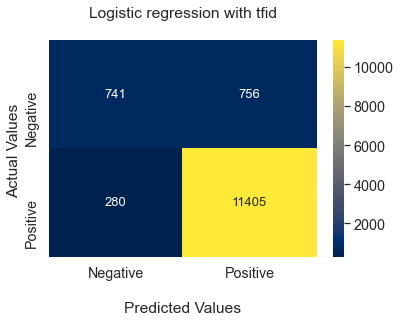

In [415]:
logisticRegressionTfidModel = gridSearchCVLogisticRegressionTfid.best_estimator_

y_hatLogisticRegressionTfid = logisticRegressionTfidModel.predict(X_testString)

precesion, recall, fscoreLRTfid, support = precision_recall_fscore_support(
    y_hatLogisticRegressionTfid, y_test["sentiment"], average="macro")

print("F-score:\n", fscoreLRTfid)

print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], y_hatLogisticRegressionTfid))
print(classification_report(y_test["sentiment"], y_hatLogisticRegressionTfid))

conf_mat = confusion_matrix(y_test["sentiment"], y_hatLogisticRegressionTfid)

print("Confusion Matrix")
displayConfusionMatrix(conf_mat, "Logistic regression with tfid\n")

In [424]:
print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], y_hatLogisticRegressionTfid))
print("Recall:", recall)

Mathews Coefficient: 0.559080224746692
Recall: 0.8317965597221928


In [426]:
precesion, recall, fscoreLRTfid, support = precision_recall_fscore_support(
    y_hatLogisticRegressionTfid, y_test["sentiment"])


[0.72575906 0.93783406]


### Multinomial Naive bayes with tf-idf

In [292]:
tfidfvect = TfidfVectorizer()
multinomialNB = MultinomialNB()

pipeline = Pipeline([('tfidf', tfidfvect), ('clf', multinomialNB)])

paramGrid = {
    'clf__alpha': (0.25, 0.5, 0.75),
    'tfidf__use_idf': (True, False),
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'tfidf__max_df': (0.25, 0.5, 0.75)
}

gridSearchCVNaiveBayesTfid = GridSearchCV(pipeline,
                            paramGrid,
                            n_jobs=-1,
                            cv=5,
                            scoring= "f1_macro")

gridSearchCVNaiveBayesTfid.fit(X_trainString, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.25, 0.5, 0.75),
                         'tfidf__max_df': (0.25, 0.5, 0.75),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
                         'tfidf__use_idf': (True, False)},
             scoring='f1_macro')

F1-score
: 0.528122158108265
              precision    recall  f1-score   support

           0       0.67      0.06      0.11      1497
           1       0.89      1.00      0.94     11685

    accuracy                           0.89     13182
   macro avg       0.78      0.53      0.53     13182
weighted avg       0.87      0.89      0.85     13182



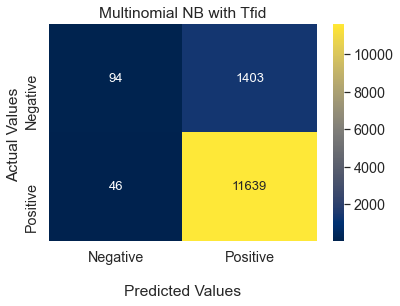

In [313]:
#Estimating the model
naiveBayesTfidModel = gridSearchCVNaiveBayesTfid.best_estimator_

y_hatNaiveBayes = naiveBayesTfidModel.predict(X_testString)

precesion, recall, fscoreNB, support = precision_recall_fscore_support(
    y_hatNaiveBayes, y_test, average="macro")

print("F1-score\n:",fscoreNB)

print(
    classification_report(
        y_test,
        naiveBayesTfidModel.predict(X_testString)))

conf_mat_nbtfid = confusion_matrix(y_test, y_hatNaiveBayes)

displayConfusionMatrix(conf_mat_nbtfid, "Multinomial NB with Tfid")

In [440]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], y_hatNaiveBayes))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], y_hatNaiveBayes))

precesion, recallNB, fscoreNBTrail, support = precision_recall_fscore_support(
    y_hatNaiveBayes, y_test["sentiment"])
print(precesion)
recall_score(y_hatNaiveBayes, y_test["sentiment"], pos_label= 0)



Balanced Accuracy score: 0.529427790111674
Mathews Coefficient: 0.18216997061794568
[0.06279225 0.99606333]


0.6714285714285714

## Random Forest with tf-idf

In [319]:
tfidfvectRF = TfidfVectorizer()
randomForestClassifier = RandomForestClassifier(random_state=7)

pipeline = Pipeline([('tfidf', tfidfvectRF), ('clf', randomForestClassifier)])

paramGrid = {
    'clf__n_estimators': [20, 100, 150],
    'clf__max_depth': [15, 30, 50],
    'tfidf__use_idf': (True, False),
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'tfidf__max_df': (0.25, 0.5, 0.75)
}

gridSearchCVRandomForestTfid = GridSearchCV(pipeline,
                                            paramGrid,
                                            n_jobs=-1,
                                            cv=3,
                                            scoring="f1_macro")

gridSearchCVRandomForestTfid.fit(X_trainString, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=7))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [15, 30, 50],
                         'clf__n_estimators': [20, 100, 150],
                         'tfidf__max_df': (0.25, 0.5, 0.75),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
                         'tfidf__use_idf': (True, False)},
             scoring='f1_macro')

F1 score: 0.5019392033542978
              precision    recall  f1-score   support

           0       0.78      0.03      0.06      1497
           1       0.89      1.00      0.94     11685

    accuracy                           0.89     13182
   macro avg       0.83      0.52      0.50     13182
weighted avg       0.88      0.89      0.84     13182



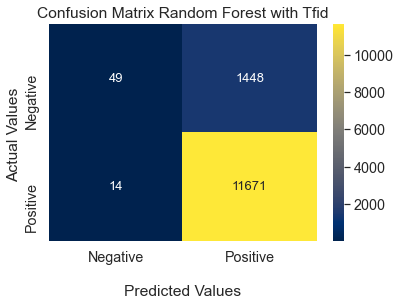

In [320]:
randomForestTfidModel = gridSearchCVRandomForestTfid.best_estimator_

y_hatRandomForestTfid = randomForestTfidModel.predict(X_testString)

precesion, recall, fscoreRFTfid, support = precision_recall_fscore_support(
    y_hatRandomForestTfid, y_test, average="macro")

print("F1 score:", fscoreRFTfid)

print(classification_report(y_test, y_hatRandomForestTfid))

conf_mat_rftfid = confusion_matrix(y_test, y_hatRandomForestTfid)

displayConfusionMatrix(conf_mat_rftfid, "Confusion Matrix Random Forest with Tfid")

In [436]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], y_hatRandomForestTfid))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], y_hatRandomForestTfid))

recall_score(y_hatRandomForestTfid, y_test["sentiment"])

Balanced Accuracy score: 0.5157670068420966
Mathews Coefficient: 0.14507209057166276


0.8896257336687248

## Logistic Regression with Count vector

In [323]:
countVector = CountVectorizer()
logisticRegression = LogisticRegression()

CParamRange = [0.1, 1, 10, 100]
penalty = ["l1", 'l2']
solver = ['lbfgs', 'sag']

pipeline = Pipeline([('vect', countVector), ('clf', logisticRegression)])

paramGrid = {
    'clf__C': CParamRange,
    'clf__penalty': penalty,
    'clf__solver': solver,
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'vect__max_df': (0.25, 0.5, 0.75)
}

gridSearchCVLogisticRegressionCV = GridSearchCV(pipeline,
                                                paramGrid,
                                                n_jobs=-1,
                                                cv=3,
                                                scoring="f1_macro")

gridSearchCVLogisticRegressionCV.fit(X_trainString, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['lbfgs', 'sag'],
                         'vect__max_df': (0.25, 0.5, 0.75),
                         'vect__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1_macro')

F-score:
 0.7743415923171375
              precision    recall  f1-score   support

           0       0.71      0.51      0.59      1497
           1       0.94      0.97      0.96     11685

    accuracy                           0.92     13182
   macro avg       0.83      0.74      0.77     13182
weighted avg       0.91      0.92      0.91     13182

Confusion Matrix


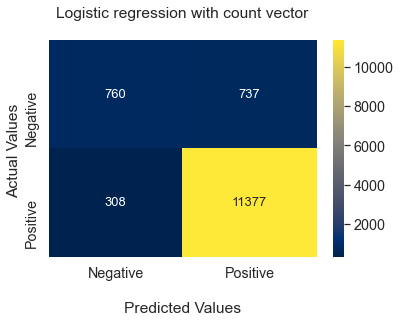

In [324]:
logisticRegressionCVModel = gridSearchCVLogisticRegressionCV.best_estimator_

y_hatLogisticRegressionCV = logisticRegressionCVModel.predict(X_testString)

precesion, recall, fscoreLRCountVector, support = precision_recall_fscore_support(
    y_hatLogisticRegressionCV, y_test, average="macro")

print("F-score:\n", fscoreLRCountVector)

print(classification_report(y_test, y_hatLogisticRegressionCV))

conf_mat = confusion_matrix(y_test, y_hatLogisticRegressionCV)

print("Confusion Matrix")
displayConfusionMatrix(conf_mat, "Logistic regression with count vector\n")

In [441]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], y_hatLogisticRegressionCV))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], y_hatLogisticRegressionCV))

recall_score(y_hatLogisticRegressionCV, y_test["sentiment"])

Balanced Accuracy score: 0.7406617256764277
Mathews Coefficient: 0.5596710846367481


0.9391613009740796

## Multinomial Naiye Bayes with Count vector

In [326]:
countVector = CountVectorizer()
multinomialNB = MultinomialNB()

pipeline = Pipeline([('vect', countVector), ('clf', multinomialNB)])

paramGrid = {
    'clf__alpha': (0.25, 0.5, 0.75),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'vect__max_df': (0.25, 0.5, 0.75),
    'vect__min_df': (0.25, 0.5, 0.75)
}

gridSearchCVMultiNBCountVector = GridSearchCV(pipeline,
                                              paramGrid,
                                              n_jobs=-1,
                                              cv=10,
                                              scoring="f1_macro")

gridSearchCVMultiNBCountVector.fit(X_trainString, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.25, 0.5, 0.75),
                         'vect__max_df': (0.25, 0.5, 0.75),
                         'vect__min_df': (0.25, 0.5, 0.75),
                         'vect__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1_macro')

F1-score
: 0.4773841574360606
              precision    recall  f1-score   support

           0       0.20      0.01      0.02      1497
           1       0.89      1.00      0.94     11685

    accuracy                           0.88     13182
   macro avg       0.54      0.50      0.48     13182
weighted avg       0.81      0.88      0.83     13182



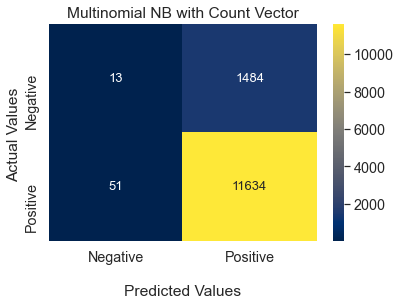

In [327]:
#Estimating the model
naiveBayesCountVectorModel = gridSearchCVMultiNBCountVector.best_estimator_

y_hatNaiveBayesCountVector = naiveBayesCountVectorModel.predict(X_testString)

precesion, recall, fscoreNBCV, support = precision_recall_fscore_support(
    y_hatNaiveBayesCountVector, y_test, average="macro")

print("F1-score\n:", fscoreNBCV)

print(classification_report(y_test, y_hatNaiveBayesCountVector))

conf_mat_nb_cv = confusion_matrix(y_test, y_hatNaiveBayesCountVector)

displayConfusionMatrix(conf_mat_nb_cv, "Multinomial NB with Count Vector")

In [442]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], y_hatNaiveBayesCountVector))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], y_hatNaiveBayesCountVector))

recall_score(y_hatNaiveBayesCountVector, y_test["sentiment"])

Balanced Accuracy score: 0.5021597323873249
Mathews Coefficient: 0.01971657135962158


0.8868729989327642

## Random Forest with Count Vector

In [330]:
countVector = CountVectorizer()
randomForestClassifier = RandomForestClassifier(random_state=7)

pipeline = Pipeline([('vect', countVector), ('clf', randomForestClassifier)])

paramGrid = {
    'clf__n_estimators': [20, 100, 150],
    'clf__max_depth': [15, 30, 50],
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'vect__max_df': (0.25, 0.5, 0.75),
    'vect__min_df': (0.25, 0.5, 0.75)
}

gridSearchCVRandomForestCountVector = GridSearchCV(pipeline,
                                                   paramGrid,
                                                   n_jobs=-1,
                                                   cv=3,
                                                   scoring="f1_macro")

gridSearchCVRandomForestCountVector.fit(X_trainString, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=7))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [15, 30, 50],
                         'clf__n_estimators': [20, 100, 150],
                         'vect__max_df': (0.25, 0.5, 0.75),
                         'vect__min_df': (0.25, 0.5, 0.75),
                         'vect__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1_macro')

F1 score: 0.4718555309194368
              precision    recall  f1-score   support

           0       0.11      0.00      0.01      1497
           1       0.89      1.00      0.94     11685

    accuracy                           0.88     13182
   macro avg       0.50      0.50      0.47     13182
weighted avg       0.80      0.88      0.83     13182



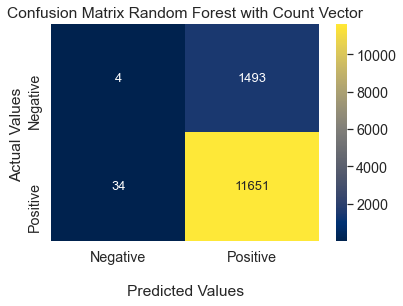

In [331]:
randomForestCountVectorModel = gridSearchCVRandomForestCountVector.best_estimator_

y_hatRandomForestCountVector = randomForestCountVectorModel.predict(X_testString)

precesion, recall, fscoreRFCV, support = precision_recall_fscore_support(
    y_hatRandomForestCountVector, y_test, average="macro")

print("F1 score:", fscoreRFCV)

print(classification_report(y_test, y_hatRandomForestCountVector))

conf_mat_rf_cv = confusion_matrix(y_test, y_hatRandomForestCountVector)

displayConfusionMatrix(conf_mat_rf_cv, "Confusion Matrix Random Forest with Count Vector")

In [443]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], y_hatRandomForestCountVector))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], y_hatRandomForestCountVector))

recall_score(y_hatRandomForestCountVector, y_test["sentiment"])

Balanced Accuracy score: 0.4998811486901917
Mathews Coefficient: -0.001406707014105792


0.8864120511259891

In [333]:
dataFrameSplitTestTrainCombined = pd.concat([X_train, X_test])

dataFrameSplitTestTrainCombined.head()

dataFrameSplitTestTrainCombined.shape

(52725, 2)

In [334]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.to_frame()
y_train = y_train.reset_index()
y_test = y_test.to_frame()
y_test = y_test.reset_index()

### Word2Vec

In [368]:
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

type(X_train)

word2vec_model_file = '/Users/rakshith/Downloads/word2vec' + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(dataFrameSplitTestTrainCombined['review']).values
# Train the Word2Vec Model

w2v_model = gensim.models.Word2Vec(stemmed_tokens,
                                   min_count=1,
                                   vector_size=1000,
                                   window=window,
                                   workers=workers)

gensim.models.Word2Vec()
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 14.667675256729126


In [369]:
sg_w2v_model = Word2Vec.load(word2vec_model_file)

In [370]:
word2vec_filename = '/Users/rakshith/Downloads/' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model.wv[token] for token in row["review"]], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [371]:
word2vec_df = pd.read_csv(word2vec_filename)


clf_decision_word2vec = RandomForestClassifier()

start_time = time.time()

clf_decision_word2vec.fit(word2vec_df, y_train["sentiment"])

print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 257.21646904945374


In [372]:
test_features_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model.wv[token] for token in row["review"]], axis=0)
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
        
test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)

print(classification_report(y_test["sentiment"],test_predictions_word2vec))

              precision    recall  f1-score   support

           0       0.11      1.00      0.20      1497
           1       0.00      0.00      0.00     11685

    accuracy                           0.11     13182
   macro avg       0.06      0.50      0.10     13182
weighted avg       0.01      0.11      0.02     13182



In [447]:
embeddingsSize=128

model=gensim.models.Word2Vec(X_trainTokens, vector_size=embeddingsSize, window=5, min_count=1, workers=4)

In [448]:
def getVectors(dataset):
    singleDataItemEmbedding = np.zeros(embeddingsSize)
    vectors = []
    for dataItem in dataset:
        wordCount = 0
        for word in dataItem:
            if word in model.wv.key_to_index:
                singleDataItemEmbedding = singleDataItemEmbedding + model.wv[
                    word]
                wordCount = wordCount + 1

        singleDataItemEmbedding = singleDataItemEmbedding / wordCount
        vectors.append(singleDataItemEmbedding)
    return vectors

trainReviewVectors=getVectors(X_trainTokens)
testReviewVectors = getVectors(X_testTokens)

## Random Forest with Word2Vec

In [449]:
clfRF = RandomForestClassifier(n_estimators = 100)
# Train the model on training data
clfRF.fit(trainReviewVectors, y_train["sentiment"]);

testLabelsPredicted=list(clfRF.predict(testReviewVectors))

#print results
print("####################RESULTS OF Random Forest CLASSIFIER##################")

precesion, recall, fscoreWordVec, support = precision_recall_fscore_support(
    testLabelsPredicted, y_test["sentiment"], average="macro")

print("F1 score:", fscoreWordVec)

print(classification_report(y_test["sentiment"], testLabelsPredicted))

####################RESULTS OF Random Forest CLASSIFIER##################
F1 score: 0.5819465780866541
              precision    recall  f1-score   support

           0       0.71      0.13      0.22      1497
           1       0.90      0.99      0.94     11685

    accuracy                           0.90     13182
   macro avg       0.80      0.56      0.58     13182
weighted avg       0.88      0.90      0.86     13182



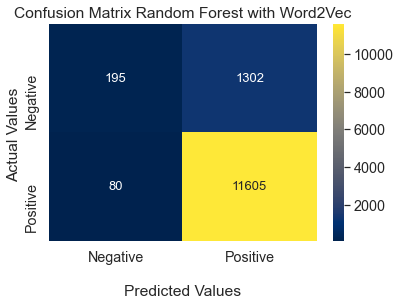

In [450]:
conf_mat_rf_w2v = confusion_matrix(y_test["sentiment"], testLabelsPredicted)

displayConfusionMatrix(conf_mat_rf_w2v, "Confusion Matrix Random Forest with Word2Vec")

In [460]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], testLabelsPredicted))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], testLabelsPredicted))

recall_score(testLabelsPredicted, y_test["sentiment"])

Balanced Accuracy score: 0.561707068394384
Mathews Coefficient: 0.27397514567052084


0.899124506081971

## Logistic Regression with Word2Vec

In [451]:
logisticReg = LogisticRegression()
# Train the model on training data
logisticReg.fit(trainReviewVectors, y_train["sentiment"]);

testLabelsPredictedLogisticRegression=list(logisticReg.predict(testReviewVectors))

#print results
print("####################RESULTS OF Logistic Regression CLASSIFIER##################")

precesion, recall, fscoreWordVecLogisticReg, support = precision_recall_fscore_support(
    testLabelsPredictedLogisticRegression, y_test["sentiment"], average="macro")

print("F1 score:", fscoreWordVecLogisticReg)

print(classification_report(y_test["sentiment"], testLabelsPredictedLogisticRegression))

####################RESULTS OF Logistic Regression CLASSIFIER##################
F1 score: 0.6299536284061541
              precision    recall  f1-score   support

           0       0.66      0.21      0.31      1497
           1       0.91      0.99      0.94     11685

    accuracy                           0.90     13182
   macro avg       0.79      0.60      0.63     13182
weighted avg       0.88      0.90      0.87     13182



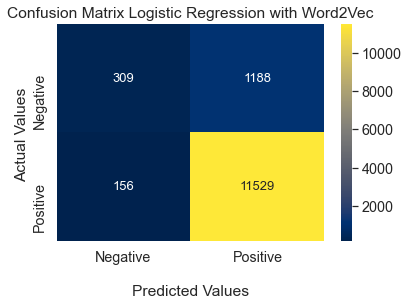

In [490]:
conf_mat_lr_w2v = confusion_matrix(y_test["sentiment"], testLabelsPredictedLogisticRegression)

displayConfusionMatrix(conf_mat_lr_w2v, "Confusion Matrix Logistic Regression with Word2Vec")

In [461]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], testLabelsPredictedLogisticRegression))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], testLabelsPredictedLogisticRegression))

recall_score(testLabelsPredictedLogisticRegression, y_test["sentiment"])

Balanced Accuracy score: 0.596531188178668
Mathews Coefficient: 0.33205046591825743


0.9065817409766455

## Multinomial Naive Bayes with Word2Vec

In [456]:
clfNB = MultinomialNB()

scaler = MinMaxScaler()
scaledTrainX= scaler.fit_transform(trainReviewVectors)
scaledTestX = scaler.fit_transform(testReviewVectors)
clfNB.fit(scaledTrainX, y_train["sentiment"])

#test naive bayes accuracy
testLabelsPredictedNaiveBayes=list(clfNB.predict(scaledTestX))

precesion, recall, fscoreWordVecNB, support = precision_recall_fscore_support(
    testLabelsPredictedNaiveBayes, y_test["sentiment"], average="macro")

print("F1 score:", fscoreWordVecNB)

#print results
print("####################RESULTS OF NAIVE BAYES CLASSIFIER##################")
print(classification_report(y_test["sentiment"], testLabelsPredictedNaiveBayes))

F1 score: 0.4705863213204619
####################RESULTS OF NAIVE BAYES CLASSIFIER##################
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1497
           1       0.89      1.00      0.94     11685

    accuracy                           0.89     13182
   macro avg       0.94      0.50      0.47     13182
weighted avg       0.90      0.89      0.83     13182



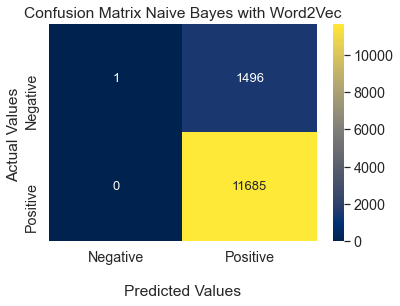

In [457]:
conf_mat_rf_w2v = confusion_matrix(y_test["sentiment"], testLabelsPredictedNaiveBayes)

displayConfusionMatrix(conf_mat_rf_w2v, "Confusion Matrix Naive Bayes with Word2Vec")

In [462]:
print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], testLabelsPredictedNaiveBayes))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], testLabelsPredictedNaiveBayes))

recall_score(testLabelsPredictedNaiveBayes, y_test["sentiment"])

Balanced Accuracy score: 0.5003340013360054
Mathews Coefficient: 0.024334883876507948


0.8865033002048402

### SMOTE

## Multinomial Naive Bayes with Tfidf

In [470]:
smote = SMOTE(sampling_strategy="minority", n_jobs=-1)

nb_pipe2 = PipelineImblearn([('tfidf', TfidfVectorizer()), ('sampler', smote),
                             ('model', MultinomialNB())])


def evaluate_model(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    pipe: Pipeline,
) -> None:

    model = pipe.fit(X_train["review_lemmatised"], y_train["sentiment"])

    pred = model.predict(X_test["review_lemmatised"])

    print(classification_report(y_test["sentiment"], pred))

    conf_mat = confusion_matrix(y_test["sentiment"],
                                       pred)

    displayConfusionMatrix(conf_mat, "")

    print("balanced_accuracy",
          balanced_accuracy_score(y_test["sentiment"], pred))

    print("Mathews Coefficient:", matthews_corrcoef(y_test["sentiment"], pred))

In [471]:
from functools import partial

evaluate_pipeline = partial(evaluate_model,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

              precision    recall  f1-score   support

           0       0.36      0.59      0.45      1497
           1       0.94      0.87      0.90     11685

    accuracy                           0.84     13182
   macro avg       0.65      0.73      0.68     13182
weighted avg       0.88      0.84      0.85     13182



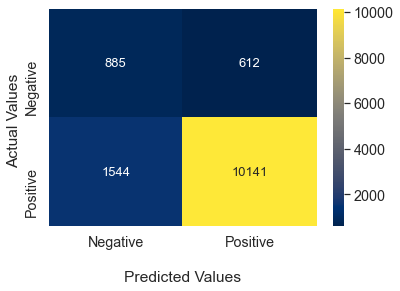

balanced_accuracy 0.729523574320228
Mathews Coefficient: 0.37566780071702177


In [472]:
evaluate_pipeline(nb_pipe2)

## Logistic Regression with Tf-idf

              precision    recall  f1-score   support

           0       0.46      0.77      0.58      1497
           1       0.97      0.89      0.93     11685

    accuracy                           0.87     13182
   macro avg       0.72      0.83      0.75     13182
weighted avg       0.91      0.87      0.89     13182



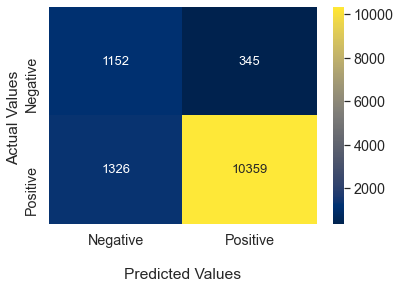

balanced_accuracy 0.8280301295787982
Mathews Coefficient: 0.5327767796907938


In [473]:
nb_pipeLogisticRegression = PipelineImblearn([('tfidf', TfidfVectorizer()), ('sampler', smote),
                             ('model', LogisticRegression())])

evaluate_pipeline(nb_pipeLogisticRegression)

## Random Forest with Tf-idf

              precision    recall  f1-score   support

           0       0.49      0.31      0.38      1497
           1       0.92      0.96      0.94     11685

    accuracy                           0.89     13182
   macro avg       0.70      0.64      0.66     13182
weighted avg       0.87      0.89      0.87     13182



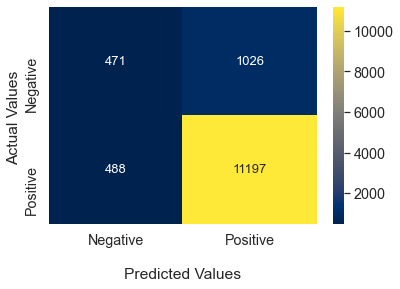

balanced_accuracy 0.6364331572859026
Mathews Coefficient: 0.3333319740315377


In [476]:
nb_pipeLogisticRegression = PipelineImblearn([
    ('tfidf', TfidfVectorizer()), ('sampler', smote),
    ('model', RandomForestClassifier(n_estimators=100))
])

evaluate_pipeline(nb_pipeLogisticRegression)

## Multinomial Naive Bayes with CountVector

              precision    recall  f1-score   support

           0       0.35      0.47      0.40      1497
           1       0.93      0.89      0.91     11685

    accuracy                           0.84     13182
   macro avg       0.64      0.68      0.65     13182
weighted avg       0.86      0.84      0.85     13182



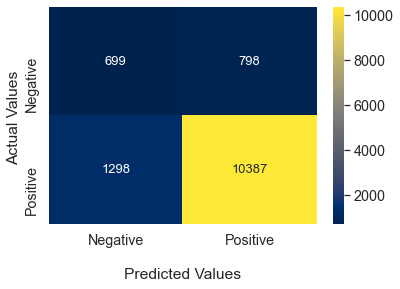

balanced_accuracy 0.6779256416127077
Mathews Coefficient: 0.31491022929689505


In [477]:
nb_pipeMultinomialNBCountVector = PipelineImblearn([
    ('vect', CountVectorizer()), ('sampler', smote), ('model', MultinomialNB())
])

evaluate_pipeline(nb_pipeMultinomialNBCountVector)

## Logistic Regression with CountVector

              precision    recall  f1-score   support

           0       0.47      0.62      0.53      1497
           1       0.95      0.91      0.93     11685

    accuracy                           0.88     13182
   macro avg       0.71      0.76      0.73     13182
weighted avg       0.89      0.88      0.88     13182



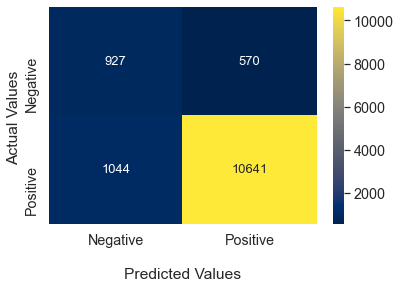

balanced_accuracy 0.7649465812240656
Mathews Coefficient: 0.47146351056972563


In [478]:
nb_pipeLogisticRegressionCountVector = PipelineImblearn([
    ('vect', CountVectorizer()), ('sampler', smote), ('model', LogisticRegression())
])

evaluate_pipeline(nb_pipeLogisticRegressionCountVector)

## Random Forest with CountVector

              precision    recall  f1-score   support

           0       0.40      0.34      0.37      1497
           1       0.92      0.94      0.93     11685

    accuracy                           0.87     13182
   macro avg       0.66      0.64      0.65     13182
weighted avg       0.86      0.87      0.86     13182



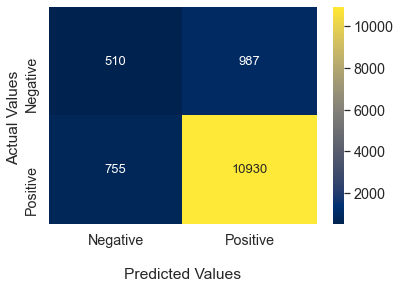

balanced_accuracy 0.6380343056673896
Mathews Coefficient: 0.297381232320594


In [479]:
nb_pipeRandomForestCountVector = PipelineImblearn([
    ('vect', CountVectorizer()), ('sampler', smote),
    ('model', RandomForestClassifier(n_estimators=100))
])

evaluate_pipeline(nb_pipeRandomForestCountVector)

## Random Forest with Word2Vec

In [480]:
#X_trainSampled, y_trainSampled = smote.fit_resample(X_train, y_train)

X_trainSampledWord2Vec, y_trainSampled = smote.fit_resample(
    trainReviewVectors, y_train["sentiment"])

In [487]:
clfRFSmote = RandomForestClassifier(n_estimators = 100)
# Train the model on training data
clfRFSmote.fit(X_trainSampledWord2Vec, y_trainSampled);

testLabelsPredictedRFSmote =list(clfRFSmote.predict(testReviewVectors))

#print results
print("####################RESULTS OF Random Forest CLASSIFIER##################")

precesion, recall, fscoreRFWordVec, support = precision_recall_fscore_support(
    testLabelsPredictedRFSmote, y_test["sentiment"], average="macro")

print("F1 score:", fscoreRFWordVec)

print(classification_report(y_test["sentiment"], testLabelsPredictedRFSmote))

####################RESULTS OF Random Forest CLASSIFIER##################
F1 score: 0.6610796595394576
              precision    recall  f1-score   support

           0       0.39      0.41      0.40      1497
           1       0.92      0.92      0.92     11685

    accuracy                           0.86     13182
   macro avg       0.66      0.67      0.66     13182
weighted avg       0.86      0.86      0.86     13182



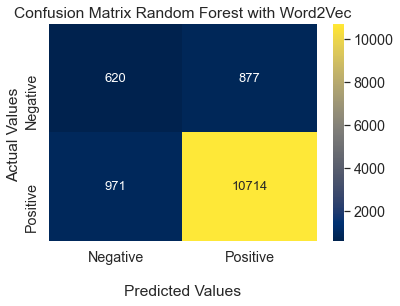

Balanced Accuracy score: 0.6655318338860005
Mathews Coefficient: 0.32243430215254965


0.9243378483306013

In [489]:
conf_mat_rf_w2v_smote = confusion_matrix(y_test["sentiment"], testLabelsPredictedRFSmote)

displayConfusionMatrix(conf_mat_rf_w2v_smote, "Confusion Matrix Random Forest with Word2Vec")

print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], testLabelsPredictedRFSmote))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], testLabelsPredictedRFSmote))


## Logistic Regression with Word2Vec

In [491]:
clfLRSmote = LogisticRegression()
# Train the model on training data
clfLRSmote.fit(X_trainSampledWord2Vec, y_trainSampled);

testLabelsPredictedLogisticRegressionSmote =list(clfLRSmote.predict(testReviewVectors))

#print results
print("####################RESULTS OF Logistic Regression CLASSIFIER##################")

precesion, recall, fscoreLogisticRegWordVec, support = precision_recall_fscore_support(
    testLabelsPredictedLogisticRegressionSmote, y_test["sentiment"], average="macro")

print("F1 score:", fscoreLogisticRegWordVec)

print(classification_report(y_test["sentiment"], testLabelsPredictedLogisticRegressionSmote))

####################RESULTS OF Logistic Regression CLASSIFIER##################
F1 score: 0.643686012650574
              precision    recall  f1-score   support

           0       0.30      0.77      0.43      1497
           1       0.96      0.77      0.86     11685

    accuracy                           0.77     13182
   macro avg       0.63      0.77      0.64     13182
weighted avg       0.89      0.77      0.81     13182



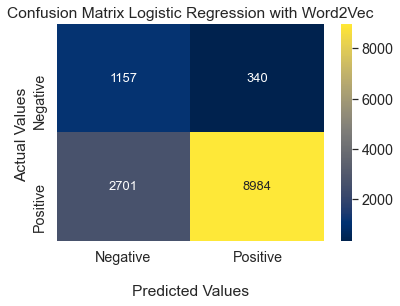

Balanced Accuracy score: 0.7708640215818886
Mathews Coefficient: 0.37776727409617017


In [493]:
conf_mat_lr_w2v_smote = confusion_matrix(y_test["sentiment"], testLabelsPredictedLogisticRegressionSmote)

displayConfusionMatrix(conf_mat_lr_w2v_smote, "Confusion Matrix Logistic Regression with Word2Vec")

print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], testLabelsPredictedLogisticRegressionSmote))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], testLabelsPredictedLogisticRegressionSmote))


## Multinomial Naiye Bayes with Word2Vec

In [497]:
clfNBSmote = MultinomialNB()
scaler = MinMaxScaler()

scaledTrainX= scaler.fit_transform(X_trainSampledWord2Vec)
scaledTestX = scaler.fit_transform(testReviewVectors)

# Train the model on training data
clfNBSmote.fit(scaledTrainX, y_trainSampled);

testLabelsPredictedNaiyeBayesSmote =list(clfNBSmote.predict(scaledTestX))

#print results
print("####################RESULTS OF Multinomial Naibe Bayes CLASSIFIER##################")

precesion, recall, fscoreNBWordVec, support = precision_recall_fscore_support(
    testLabelsPredictedNaiyeBayesSmote, y_test["sentiment"], average="macro")

print("F1 score:", fscoreNBWordVec)

print(classification_report(y_test["sentiment"], testLabelsPredictedNaiyeBayesSmote))

####################RESULTS OF Multinomial Naibe Bayes CLASSIFIER##################
F1 score: 0.551266339869281
              precision    recall  f1-score   support

           0       0.21      0.71      0.32      1497
           1       0.95      0.66      0.78     11685

    accuracy                           0.67     13182
   macro avg       0.58      0.68      0.55     13182
weighted avg       0.86      0.67      0.73     13182



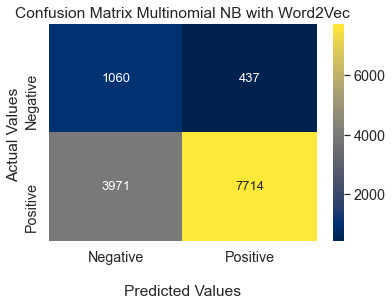

Balanced Accuracy score: 0.6841227169786728
Mathews Coefficient: 0.24050827522362642


In [498]:
conf_mat_nb_w2v_smote = confusion_matrix(y_test["sentiment"], testLabelsPredictedNaiyeBayesSmote)

displayConfusionMatrix(conf_mat_nb_w2v_smote, "Confusion Matrix Multinomial NB with Word2Vec")

print(
    "Balanced Accuracy score:",
    balanced_accuracy_score(y_test["sentiment"], testLabelsPredictedNaiyeBayesSmote))

print("Mathews Coefficient:",
      matthews_corrcoef(y_test["sentiment"], testLabelsPredictedNaiyeBayesSmote))
